# Homework: Sonar signal classification
In this workshop you will train a binary classification neural network to differentiate if sonar signals bounced against a metal cylinder or a rock.

[Info of the data](https://archive.ics.uci.edu/ml/datasets/Connectionist+Bench+(Sonar,+Mines+vs.+Rocks))

Goal: Get an accuracy higher than 0.80 in the validation set

**Outcome: Accuracy of 0.9524 in the validation set.**

## Get the data from Google Drive

In [1]:
# Import libraries to interact with Google Drive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [2]:
# Authenticate with your Google account to get access to the data
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [3]:
# Download data
download = drive.CreateFile({'id': '1rw5l3jCo2vlNc8NLrMk3KPZr6HsjNRCY'})
download.GetContentFile('sonar.csv')

In [4]:
ls

sample_data/  sonar.csv


## Do some magic below! ;)

In [40]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint

In [8]:
data = pd.read_csv('./sonar.csv')

In [9]:
data.head()

,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,...,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032,R
0,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,...,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044,R
1,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,...,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078,R
2,0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,...,0.0121,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117,R
3,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,...,0.0031,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094,R
4,0.0286,0.0453,0.0277,0.0174,0.0384,0.0990,0.1201,0.1833,0.2105,0.3039,...,0.0045,0.0014,0.0038,0.0013,0.0089,0.0057,0.0027,0.0051,0.0062,R


In [10]:
data.columns

Index(['0.0200', '0.0371', '0.0428', '0.0207', '0.0954', '0.0986', '0.1539',
       '0.1601', '0.3109', '0.2111', '0.1609', '0.1582', '0.2238', '0.0645',
       '0.0660', '0.2273', '0.3100', '0.2999', '0.5078', '0.4797', '0.5783',
       '0.5071', '0.4328', '0.5550', '0.6711', '0.6415', '0.7104', '0.8080',
       '0.6791', '0.3857', '0.1307', '0.2604', '0.5121', '0.7547', '0.8537',
       '0.8507', '0.6692', '0.6097', '0.4943', '0.2744', '0.0510', '0.2834',
       '0.2825', '0.4256', '0.2641', '0.1386', '0.1051', '0.1343', '0.0383',
       '0.0324', '0.0232', '0.0027', '0.0065', '0.0159', '0.0072', '0.0167',
       '0.0180', '0.0084', '0.0090', '0.0032', 'R'],
      dtype='object')

In [27]:
data_numpy = data.values

In [28]:
# Show data type before and after conversion
print(type(data))
print(type(data_numpy.dtype))

<class 'pandas.core.frame.DataFrame'>
<class 'numpy.dtypes.ObjectDType'>


In [29]:
# Separate input variables from output label
X = data_numpy[:, :60]
y = data_numpy[:, 60:61]

In [30]:
# Show shape of training data and labels
print("Shape of training data: ", X.shape)
print("Shape of training labels: ", y.shape)

Shape of training data:  (207, 60)
Shape of training labels:  (207, 1)


In [31]:
# Show different classes to predict
np.unique(y)

array(['M', 'R'], dtype=object)

In [34]:
# Normalizing the data to improve stability while training
sc = StandardScaler()
sc.fit(X)
X_norm = sc.transform(X)

In [35]:
# Show data before and after normalization
print("Before normalization: \n", X[1, :])
print("After normalization: \n", X_norm[1, :])

Before normalization: 
 [0.0262 0.0582 0.1099 0.1083 0.0974 0.228 0.2431 0.3771 0.5598 0.6194
 0.6333 0.706 0.5544 0.532 0.6479 0.6931 0.6759 0.7551 0.8929 0.8619
 0.7974 0.6737 0.4293 0.3648 0.5331 0.2413 0.507 0.8533 0.6036 0.8514
 0.8512 0.5045 0.1862 0.2709 0.4232 0.3043 0.6116 0.6756 0.5375 0.4719
 0.4647 0.2587 0.2129 0.2222 0.2111 0.0176 0.1348 0.0744 0.013 0.0106
 0.0033 0.0232 0.0166 0.0095 0.018 0.0244 0.0316 0.0164 0.0095 0.0078]
After normalization: 
 [-0.13089402  0.59942737  1.71912994  1.16735119  0.40146635  2.0878624
  1.96783928  2.84755057  3.24033559  3.0588314   2.99336374  3.25412687
  1.99301568  1.43153632  1.59516994  1.35054941  0.98418341  1.15587309
  1.50434322  1.13657152  0.7299634   0.19103966 -0.87578456 -1.29060301
 -0.58117267 -1.9344945  -0.79426005  0.67421422 -0.15940651  1.22329719
  1.62389684  0.30345092 -1.11702254 -0.56812432  0.12778034 -0.29870811
  1.04310888  1.58973492  1.06937304  0.8985258   1.02344674 -0.11597725
 -0.2408284   0.069046

In [36]:
# One-hot encoding of labels
onehot_enc = OneHotEncoder()
y_onehot = onehot_enc.fit_transform(y).toarray()

In [37]:
# Show labels before and after one-hot encoding
print("Before one-hot encoding: \n", y[0])
print("After one-hot encoding: \n", y_onehot[0])

Before one-hot encoding: 
 ['R']
After one-hot encoding: 
 [0. 1.]


In [79]:
# Split data in training and validation partitions
X_train, X_val, y_train, y_val = train_test_split(X_norm, y_onehot,
                                                  test_size=0.1)

In [80]:
# Show sizes of partitions
print("Size of training data: ", X_train.shape)
print("Size of training labels: ", y_train.shape)
print("Size of validation data: ", X_val.shape)
print("Size of validation labels: ", y_val.shape)

Size of training data:  (186, 60)
Size of training labels:  (186, 2)
Size of validation data:  (21, 60)
Size of validation labels:  (21, 2)


In [81]:
# Design simple neural network architecture
model = Sequential()
model.add(Dense(16, input_dim=60, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(2, activation='softmax'))

In [82]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 16)                976       
                                                                 
 dense_13 (Dense)            (None, 12)                204       
                                                                 
 dense_14 (Dense)            (None, 2)                 26        
                                                                 
Total params: 1206 (4.71 KB)
Trainable params: 1206 (4.71 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [83]:
model.compile(loss='categorical_crossentropy', optimizer='adam',
              metrics=['accuracy'])

In [76]:
checkpoint_callback = ModelCheckpoint(filepath='rnn_{epoch:02d}.weights.h5', save_weights_only=True)

In [84]:
history = model.fit(X_train, y_train, epochs=100, batch_size=12,
                    validation_data=(X_val, y_val), callbacks=[checkpoint_callback])

Epoch 1/100
16/16 [==============================] - 1s 17ms/step - loss: 0.7318 - accuracy: 0.5323 - val_loss: 0.6881 - val_accuracy: 0.4286
Epoch 2/100
16/16 [==============================] - 0s 6ms/step - loss: 0.6362 - accuracy: 0.6344 - val_loss: 0.6190 - val_accuracy: 0.5714
Epoch 3/100
16/16 [==============================] - 0s 5ms/step - loss: 0.5725 - accuracy: 0.6935 - val_loss: 0.5727 - val_accuracy: 0.6190
Epoch 4/100
16/16 [==============================] - 0s 6ms/step - loss: 0.5287 - accuracy: 0.7473 - val_loss: 0.5352 - val_accuracy: 0.7143
Epoch 5/100
16/16 [==============================] - 0s 7ms/step - loss: 0.4933 - accuracy: 0.7957 - val_loss: 0.5005 - val_accuracy: 0.7619
Epoch 6/100
16/16 [==============================] - 0s 7ms/step - loss: 0.4571 - accuracy: 0.8118 - val_loss: 0.4611 - val_accuracy: 0.7619
Epoch 7/100
16/16 [==============================] - 0s 7ms/step - loss: 0.4247 - accuracy: 0.8441 - val_loss: 0.4288 - val_accuracy: 0.8095
Epoch 8/100


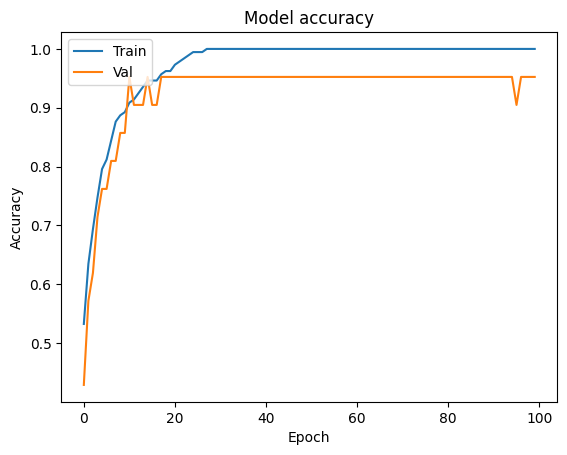

In [85]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

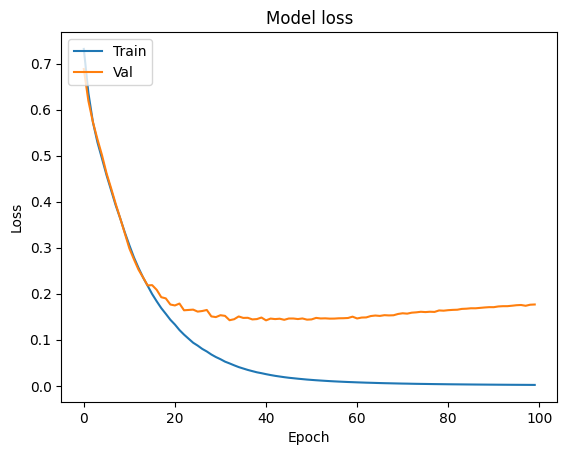

In [86]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()